In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
import pandas as pd
import numpy as np
import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Flatten, Dense,Dropout,Activation,Bidirectional, LSTM, Embedding, GlobalAveragePooling1D
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('bbc-news-data.csv', sep='\t')

In [ ]:
df.head(10)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [ ]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
def preprocess(text, stem=False):
  words = text.lower()
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  text = tokenizer.tokenize(words)
  tokens = []
  for token in text:
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [ ]:
df['content']=df['content'].apply(lambda x : preprocess(x))

In [ ]:
df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,quarterly profits us media giant timewarner ju...
1,business,002.txt,Dollar gains on Greenspan speech,dollar hit highest level euro almost three mon...
2,business,003.txt,Yukos unit buyer faces loan claim,owners embattled russian oil giant yukos ask b...
3,business,004.txt,High fuel prices hit BA's profits,british airways blamed high fuel prices 40 dro...
4,business,005.txt,Pernod takeover talk lifts Domecq,shares uk drinks food firm allied domecq risen...


In [ ]:
df=df.drop(['filename','title'],axis=1)

In [ ]:
df.head()

,category,content
0,business,quarterly profits us media giant timewarner ju...
1,business,dollar hit highest level euro almost three mon...
2,business,owners embattled russian oil giant yukos ask b...
3,business,british airways blamed high fuel prices 40 dro...
4,business,shares uk drinks food firm allied domecq risen...


In [ ]:
label = df.category
data = df.content

In [ ]:
train_data, val_data, label_train, label_val = train_test_split(data, label, train_size=0.8)

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token = "<OOV>") # Out of Vocab
tokenizer.fit_on_texts(train_data)
tokenizer.fit_on_texts(val_data)

In [ ]:
sequences_train = tokenizer.texts_to_sequences(train_data)
sequences_val = tokenizer.texts_to_sequences(val_data)
train_data = pad_sequences(sequences_train, maxlen=256, padding="post", truncating="post")
val_data = pad_sequences(sequences_val, maxlen=256, padding="post", truncating="post")

In [ ]:
print(label_train)

1761            sport
1893             tech
1175         politics
315          business
207          business
            ...      
1743            sport
846     entertainment
1180         politics
1221         politics
1664            sport
Name: category, Length: 1780, dtype: object


In [ ]:
le = LabelEncoder()
le.fit(label_train)
le.fit(label_val)
label_train = le.transform(label_train)
label_val = le.transform(label_val)

In [ ]:
model= Sequential()
model.add(Embedding(input_dim=20000, output_dim=32, input_length=256))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5,activation='softmax'))

In [ ]:
adam =Adam(learning_rate=0.001)
model.compile(adam , loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(monitor='val_loss', mode='auto', patience=10 ,restore_best_weights=True)

In [ ]:
history = model.fit(train_data,label_train,            
                    epochs=70,validation_data=(val_data, label_val), callbacks=callback)

Epoch 1/70
56/56 [==============================] - 38s 536ms/step - loss: 1.4787 - accuracy: 0.3152 - val_loss: 1.1221 - val_accuracy: 0.5528
Epoch 2/70
56/56 [==============================] - 28s 497ms/step - loss: 0.9980 - accuracy: 0.5258 - val_loss: 0.8158 - val_accuracy: 0.6112
Epoch 3/70
56/56 [==============================] - 29s 516ms/step - loss: 0.5573 - accuracy: 0.7612 - val_loss: 0.4705 - val_accuracy: 0.8494
Epoch 4/70
56/56 [==============================] - 28s 496ms/step - loss: 0.2303 - accuracy: 0.9376 - val_loss: 0.2752 - val_accuracy: 0.9281
Epoch 5/70
56/56 [==============================] - 27s 491ms/step - loss: 0.0786 - accuracy: 0.9843 - val_loss: 0.3220 - val_accuracy: 0.9169
Epoch 6/70
56/56 [==============================] - 28s 492ms/step - loss: 0.0393 - accuracy: 0.9944 - val_loss: 0.4732 - val_accuracy: 0.8989
Epoch 7/70
56/56 [==============================] - 27s 490ms/step - loss: 0.0477 - accuracy: 0.9921 - val_loss: 0.6621 - val_accuracy: 0.8539

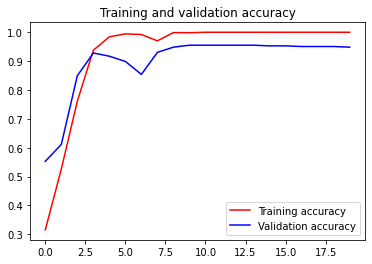

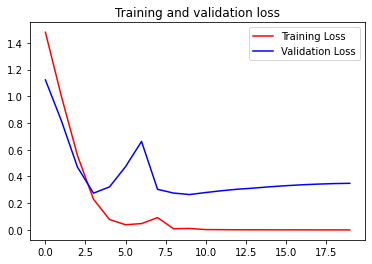

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()